In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

# Set device: use GPU if available, otherwise CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [14]:
# Define the transformation: resize and convert images to tensors.
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Check for the HAR_Images folder.
data_dir = 'HAR_Images'
if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"Directory '{data_dir}' not found. Check your folder location.")

# Load the images using ImageFolder (expects one folder per class).
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print("Found classes:", dataset.classes)

# Split the dataset: 80% training, 20% testing.
num_samples = len(dataset)
train_size = int(0.8 * num_samples)
test_size = num_samples - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
print(f"Total samples: {num_samples}, Training: {train_size}, Testing: {test_size}")

# Create DataLoaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Found classes: ['Catch', 'Clap', 'Hammering']
Total samples: 5058, Training: 4046, Testing: 1012


In [15]:
num_classes = len(dataset.classes)

# Define the model using nn.Sequential.
model = nn.Sequential(
    nn.Flatten(),                         # Flatten the image (3 x 64 x 64) into a vector.
    nn.Linear(3 * 64 * 64, 512),           # First hidden layer.
    nn.ReLU(),                            # Activation.
    nn.Linear(512, 128),                  # Second hidden layer.
    nn.ReLU(),                            # Activation.
    nn.Linear(128, num_classes)           # Output layer.
).to(device)

print(model)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=12288, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=3, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
num_epochs = 25  # You can adjust the number of epochs if needed.

# Prepare lists to record our results.
train_losses = []
train_accuracies = []
test_accuracies = []


In [17]:
for epoch in range(num_epochs):
    model.train()  # Switch to training mode.
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training loop.
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total_train
    epoch_train_acc = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_train_acc)
    
    # Evaluate on test set.
    model.eval()  # Switch to evaluation mode.
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    epoch_test_acc = correct_test / total_test
    test_accuracies.append(epoch_test_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | Test Acc: {epoch_test_acc:.4f}")


Epoch 1/25 | Loss: 0.6529 | Train Acc: 0.6923 | Test Acc: 0.8043
Epoch 2/25 | Loss: 0.3420 | Train Acc: 0.8613 | Test Acc: 0.9101
Epoch 3/25 | Loss: 0.2487 | Train Acc: 0.8987 | Test Acc: 0.8814
Epoch 4/25 | Loss: 0.1987 | Train Acc: 0.9184 | Test Acc: 0.8340
Epoch 5/25 | Loss: 0.1657 | Train Acc: 0.9288 | Test Acc: 0.9684
Epoch 6/25 | Loss: 0.1336 | Train Acc: 0.9439 | Test Acc: 0.9625
Epoch 7/25 | Loss: 0.1100 | Train Acc: 0.9582 | Test Acc: 0.9555
Epoch 8/25 | Loss: 0.0895 | Train Acc: 0.9634 | Test Acc: 0.9279
Epoch 9/25 | Loss: 0.1600 | Train Acc: 0.9380 | Test Acc: 0.9368
Epoch 10/25 | Loss: 0.0792 | Train Acc: 0.9694 | Test Acc: 0.9763
Epoch 11/25 | Loss: 0.0807 | Train Acc: 0.9711 | Test Acc: 0.9763
Epoch 12/25 | Loss: 0.0596 | Train Acc: 0.9773 | Test Acc: 0.9427
Epoch 13/25 | Loss: 0.1104 | Train Acc: 0.9587 | Test Acc: 0.9753
Epoch 14/25 | Loss: 0.0404 | Train Acc: 0.9849 | Test Acc: 0.9901
Epoch 15/25 | Loss: 0.0250 | Train Acc: 0.9913 | Test Acc: 0.9832
Epoch 16/25 | Loss:

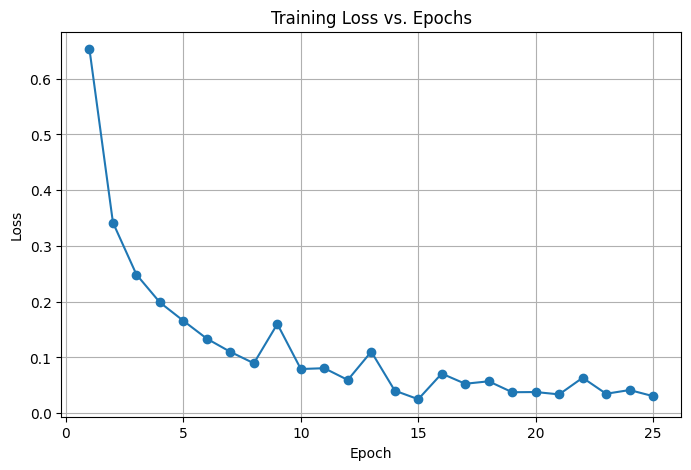

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


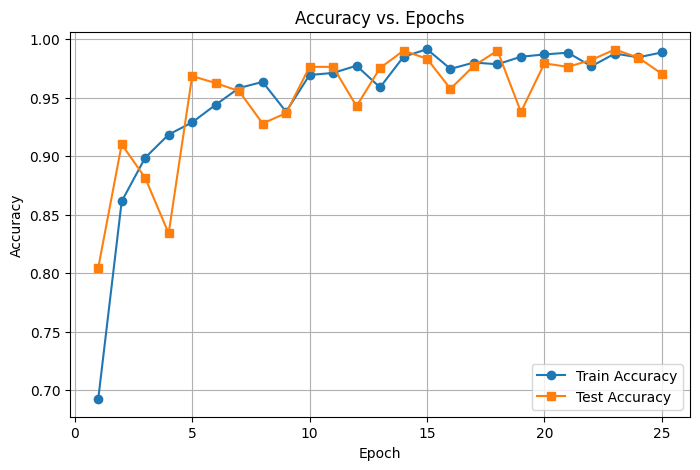

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='s', label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## References

1. Assignment Instructions from the “Assignment06_Instructions.pdf” file provided.
2. Provided Notebook – The structure and style were adapted from your “ANN_IrisDataClassification.ipynb” notebook.
3. PyTorch Documentation – For details on modules like nn.Sequential, DataLoader, and others used in the code.